In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## <Class1 : furnitue>

In [26]:
Class2 = pd.read_csv('C:/Users/wjssm/Desktop/lpoint/modeling/Class2.csv')
Class2['Date'] = pd.date_range('2018-04-01', '2018-09-30').strftime('%Y-%m-%d')
Class2['Date'] =pd.to_datetime(Class2['Date'])
Class2 = Class2.set_index('Date')
Class2.head()

,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,electronic
Date,,,,,
2018-04-01,693,68.443769,1490.337920,34.270517,173.555556
2018-04-02,648,58.410543,1442.700965,34.440895,183.333333
2018-04-03,623,62.658759,1425.818182,33.430657,178.444444
2018-04-04,611,62.197880,1386.578097,33.975265,176.000000
2018-04-05,530,60.585921,1443.321577,34.327122,166.222222


In [27]:
Y = Class2['BUY_CT_sum']

In [28]:
#remove original Y
Class2.drop(columns=['BUY_CT_sum'],inplace=True)
Class2.rename(columns = {'furniture' : 'naver_click'}, inplace=True)
Class2.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,electronic
Date,,,,
2018-04-01,68.443769,1490.337920,34.270517,173.555556
2018-04-02,58.410543,1442.700965,34.440895,183.333333
2018-04-03,62.658759,1425.818182,33.430657,178.444444
2018-04-04,62.197880,1386.578097,33.975265,176.000000
2018-04-05,60.585921,1443.321577,34.327122,166.222222


In [29]:
def minmax(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm

def inverse_minmax(norm,dataset):
    deNorm=norm*(dataset.max()-dataset.min())+dataset.min()
    return deNorm

In [15]:
#TOT_SESS_HR_V_mean 역수
Class2['TOT_SESS_HR_V_mean'] = 1000/Class2['TOT_SESS_HR_V_mean']
Class2.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,electronic
Date,,,,
2018-04-01,68.443769,0.670989,34.270517,173.555556
2018-04-02,58.410543,0.693144,34.440895,183.333333
2018-04-03,62.658759,0.701352,33.430657,178.444444
2018-04-04,62.197880,0.721200,33.975265,176.000000
2018-04-05,60.585921,0.692846,34.327122,166.222222


#### scaled

In [30]:
scaled_df1=minmax(Class2)
#(xi–mean(x))/stdev(x)
scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,electronic
Date,,,,
2018-04-01,0.330753,0.436655,0.637559,0.369565
2018-04-02,0.113816,0.362911,0.671148,0.456522
2018-04-03,0.205670,0.336776,0.471983,0.413043
2018-04-04,0.195705,0.276031,0.579351,0.391304
2018-04-05,0.160851,0.363872,0.648719,0.304348


In [31]:
scaled_Y = minmax(Y)

scaled_df1 = pd.concat([scaled_df1, scaled_Y], axis = 1)
scaled_df1.rename(columns={'BUY_CT_sum':'Y'}, inplace=True)

scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,electronic,Y
Date,,,,,
2018-04-01,0.330753,0.436655,0.637559,0.369565,0.676166
2018-04-02,0.113816,0.362911,0.671148,0.456522,0.617876
2018-04-03,0.205670,0.336776,0.471983,0.413043,0.585492
2018-04-04,0.195705,0.276031,0.579351,0.391304,0.569948
2018-04-05,0.160851,0.363872,0.648719,0.304348,0.465026


#### modeling

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [33]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [34]:
scaled_data.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,electronic,Y
Date,,,,,
2018-04-01,0.330753,0.456723,0.637559,0.369565,0.676166
2018-04-02,0.113816,0.533565,0.671148,0.456522,0.617876
2018-04-03,0.205670,0.562030,0.471983,0.413043,0.585492
2018-04-04,0.195705,0.630869,0.579351,0.391304,0.569948
2018-04-05,0.160851,0.532531,0.648719,0.304348,0.465026


In [35]:
#scaled_data : scaled한 데이터. 사용하려는 변수 + 마지막 칼럼은 Y
#n : 사용하는 변수 개수

scaled_data = scaled_df1
n = 4

In [53]:
scaled_Y = scaled_data['Y']

values = scaled_df1.values
# frame as supervised learning
reframed = series_to_supervised(scaled_df1, 1, 1)
reframed.drop(reframed.columns[-(n+1):-1], axis=1,inplace = True)

# split into train and test sets
values = reframed.values
n_train = int(len(scaled_data)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [54]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation ='relu'))
model.compile(loss='mse', optimizer='Adagrad')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=25, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 128 samples, validate on 54 samples
Epoch 1/300
 - 2s - loss: 0.1086 - val_loss: 0.0172
Epoch 2/300
 - 0s - loss: 0.0217 - val_loss: 0.0344
Epoch 3/300
 - 0s - loss: 0.0189 - val_loss: 0.0406
Epoch 4/300
 - 0s - loss: 0.0195 - val_loss: 0.0415
Epoch 5/300
 - 0s - loss: 0.0196 - val_loss: 0.0414
Epoch 6/300
 - 0s - loss: 0.0196 - val_loss: 0.0409
Epoch 7/300
 - 0s - loss: 0.0195 - val_loss: 0.0405
Epoch 8/300
 - 0s - loss: 0.0195 - val_loss: 0.0401
Epoch 9/300
 - 0s - loss: 0.0195 - val_loss: 0.0398
Epoch 10/300
 - 0s - loss: 0.0194 - val_loss: 0.0394
Epoch 11/300
 - 0s - loss: 0.0194 - val_loss: 0.0391
Epoch 12/300
 - 0s - loss: 0.0193 - val_loss: 0.0388
Epoch 13/300
 - 0s - loss: 0.0193 - val_loss: 0.0385
Epoch 14/300
 - 0s - loss: 0.0193 - val_loss: 0.0383
Epoch 15/300
 - 0s - loss: 0.0193 - val_loss: 0.0380
Epoch 16/300
 - 0s - loss: 0.0192 - val_loss: 0.0378
Epoch 17/300
 - 0s - loss: 0.0192 - val_loss: 0.0375
Epoch 18/300
 - 0s - loss: 0.0192 - val_loss: 0.0373
Epoch 19/3

Epoch 154/300
 - 0s - loss: 0.0182 - val_loss: 0.0291
Epoch 155/300
 - 0s - loss: 0.0182 - val_loss: 0.0290
Epoch 156/300
 - 0s - loss: 0.0182 - val_loss: 0.0290
Epoch 157/300
 - 0s - loss: 0.0182 - val_loss: 0.0290
Epoch 158/300
 - 0s - loss: 0.0182 - val_loss: 0.0290
Epoch 159/300
 - 0s - loss: 0.0182 - val_loss: 0.0289
Epoch 160/300
 - 0s - loss: 0.0182 - val_loss: 0.0289
Epoch 161/300
 - 0s - loss: 0.0182 - val_loss: 0.0289
Epoch 162/300
 - 0s - loss: 0.0182 - val_loss: 0.0289
Epoch 163/300
 - 0s - loss: 0.0182 - val_loss: 0.0288
Epoch 164/300
 - 0s - loss: 0.0182 - val_loss: 0.0288
Epoch 165/300
 - 0s - loss: 0.0182 - val_loss: 0.0288
Epoch 166/300
 - 0s - loss: 0.0182 - val_loss: 0.0288
Epoch 167/300
 - 0s - loss: 0.0182 - val_loss: 0.0288
Epoch 168/300
 - 0s - loss: 0.0182 - val_loss: 0.0287
Epoch 169/300
 - 0s - loss: 0.0182 - val_loss: 0.0287
Epoch 170/300
 - 0s - loss: 0.0182 - val_loss: 0.0287
Epoch 171/300
 - 0s - loss: 0.0182 - val_loss: 0.0287
Epoch 172/300
 - 0s - loss: 

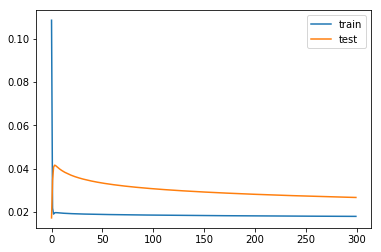

In [55]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [56]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
true_Y = Y.values[n_train+1:].reshape(yhat.shape[0],1)

In [57]:
# invert scaling for forecast
dfhat = np.concatenate((true_Y,yhat), axis = 1)
#inv_dfhat = scaler.inverse_transform(dfhat)
inv_yhat = inverse_minmax(dfhat[:,1],dfhat[:,0])

# calculate RMSE
rmse = np.sqrt(mean_squared_error(true_Y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 99.621


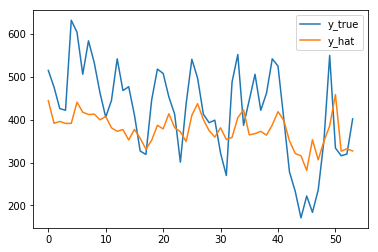

In [58]:
plt.plot(true_Y, label = 'y_true')
plt.plot(inv_yhat,label = 'y_hat')
plt.legend()

In [59]:
inv_yhat = pd.Series(inv_yhat)
inv_yhat.index = Y[n_train+1:,].index

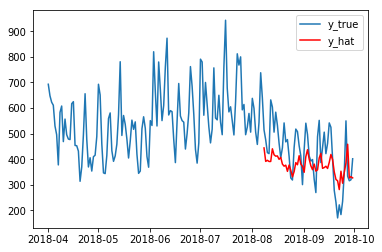

In [60]:
plt.plot(Y, label = 'y_true')
plt.plot(inv_yhat,label = 'y_hat', c='r')
plt.legend()